In [1]:
!pip install segmentation-models
!pip install tensorflow
!pip install xgboost  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 8.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1-Vm4Y4YTPSH_zM3xSTzB9RQvJqiVFwaw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-Vm4Y4YTPSH_zM3xSTzB9RQvJqiVFwaw
To: /content/Tumor.zip
100% 156M/156M [00:01<00:00, 144MB/s]


In [3]:
!pip install patool
import patoolib
patoolib.extract_archive('Tumor.zip')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 11.4 MB/s eta 0:00:00
patool: Extracting Tumor.zip ...
patool: running /usr/bin/7z x -o./Unpack_0y077ry0 -- Tumor.zip
patool: ... Tumor.zip extracted to `Tumor'.


'Tumor'

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns

In [5]:
SIZE = 64

train_images = []
train_labels = [] 

for directory_path in glob.glob("/content/Tumor/Training/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)
print(len(train_images))        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

pituitary
glioma
notumor
meningioma
5712


In [6]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("/content/Tumor/Testing/*"):
    fruit_label = directory_path.split("/")[-1]
    print(fruit_label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
print(len(test_images))            
test_images = np.array(test_images)
test_labels = np.array(test_labels)

pituitary
glioma
notumor
meningioma
1311


In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

x_train, x_test = x_train / 255.0, x_test / 255.0

In [8]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
     

In [9]:
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

In [10]:
class_no = 4
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(class_no, activation = 'softmax')(x)
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0     

In [11]:
X_for_xg = feature_extractor.predict(x_train) 

179/179 [==============================] - 7s 4ms/step


In [12]:
import xgboost as xgb
model3 = xgb.XGBClassifier()

model3.fit(X_for_xg, y_train)

XGBClassifier(objective='multi:softprob')

In [13]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = model3.predict(X_test_feature)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

41/41 [==============================] - 0s 8ms/step


Accuracy =  0.9206712433257056
              precision    recall  f1-score   support

      glioma       0.92      0.82      0.87       300
  meningioma       0.83      0.87      0.85       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.94      0.99      0.96       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



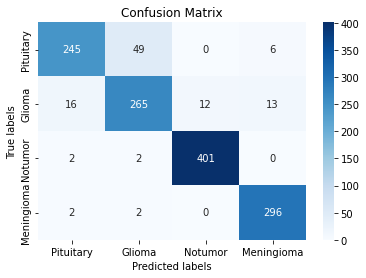

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt   
from sklearn import metrics
import pandas as pd
from sklearn.metrics import classification_report
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF)) 
ax= plt.subplot()
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True,cmap="Blues",fmt='g')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["Pituitary", "Glioma", "Notumor","Meningioma"]); 
ax.yaxis.set_ticklabels(["Pituitary", "Glioma", "Notumor","Meningioma"]);
d = {'Expected': test_labels, 'Predicted': prediction_RF}
results = pd.DataFrame(data=d)
print(classification_report(results['Expected'], results['Predicted']))